# Inventory EDA

Inventory Data contains snapshot information about sku-level tons that were available in inventory at a specific date. This data pertains to Whitby mill (1302). 

One important consideration - the numbers in inventory could decrease by:
 1) Shipments
 2) Scrapping

Our assumption for this analysis is that most of the decreases will be derived from shipments. Thus the rate of change we assume to be equal to the rate of shipments for the items in analysis. 

**Given limited time for analysis we will focus on specific blocks**
- 4" ANG
- 5X3-1/2" ANG
- 5X3" ANG
- 4X3" ANG
- 3-1/2" ANG

Exploration areas:
- Distribution of inventory through time
- Is there cyclicality to inventory from month to month, or cycle to cycle
- Analysis on the cycle lenghts (avg. and std deviations)
- **Potential features that could serve as indicators for the prediction of production quantities**
    - rate of change in inventory increasing decreasing (especially in comparison to ATP available)
    - ...

#### Dependencies

In [59]:
#dependencies for EDA
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

#### Read Dataframe

In [60]:
%store -r inv_reduced

## Peaking at Data

In [61]:
#peak
inv_reduced.head()

,calendar_day,strategy,sku,material_description,work_center,ph,shape,size,block,tons,atp
0,2020-02-23,63,106022474,"L 2X2X1/4 A36/44W/A529-50 20'00""",25000001.0,LS-Mills-Mer-Mer-Lght Shp-MBQ Angles,SHAPE_L,2X2X1/4,"2"" ANG",0.009,0.0
1,2020-02-20,63,106022474,"L 2X2X1/4 A36/44W/A529-50 20'00""",25000001.0,LS-Mills-Mer-Mer-Lght Shp-MBQ Angles,SHAPE_L,2X2X1/4,"2"" ANG",0.009,0.0
2,2020-02-19,63,106022474,"L 2X2X1/4 A36/44W/A529-50 20'00""",25000001.0,LS-Mills-Mer-Mer-Lght Shp-MBQ Angles,SHAPE_L,2X2X1/4,"2"" ANG",0.009,0.0
3,2020-02-18,63,106022474,"L 2X2X1/4 A36/44W/A529-50 20'00""",25000001.0,LS-Mills-Mer-Mer-Lght Shp-MBQ Angles,SHAPE_L,2X2X1/4,"2"" ANG",0.009,0.0
4,2020-02-17,63,106022474,"L 2X2X1/4 A36/44W/A529-50 20'00""",25000001.0,LS-Mills-Mer-Mer-Lght Shp-MBQ Angles,SHAPE_L,2X2X1/4,"2"" ANG",0.009,0.0


In [62]:
#counts and dtypes
inv_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649986 entries, 0 to 850872
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   calendar_day          649986 non-null  datetime64[ns]
 1   strategy              649986 non-null  category      
 2   sku                   649986 non-null  object        
 3   material_description  649986 non-null  object        
 4   work_center           649979 non-null  category      
 5   ph                    649986 non-null  object        
 6   shape                 647514 non-null  object        
 7   size                  647514 non-null  object        
 8   block                 626217 non-null  object        
 9   tons                  649986 non-null  float64       
 10  atp                   649986 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(2), object(6)
memory usage: 50.8+ MB


In [63]:
#creating dataframe for analysis of null blocks in inventory
null_blocks = inv_reduced[inv_reduced["block"].isna()]

In [64]:
#looking to see offenders in Angle shapes (L_SHAPE)
null_blocks[null_blocks["shape"]=="SHAPE_L"]["size"].value_counts()

2 1/2X2X1/4         1660
1 1/4X1 1/4X3/16    1032
1 1/4X1 1/4X1/8      825
2 1/2X2X3/16         812
2 1/2X2X5/16         494
3 1/2X3X3/8          489
4X3 1/2X1/4          136
1X1X1/8               57
2X1 1/2X3/16          24
1X1X1/4               23
1 1/4X1 1/4X1/4       23
1X1X3/16              22
3/4X3/4X1/8           15
1 3/4X1 3/4X1/8        3
2X1 1/2X1/4            2
8X6X3/4                1
8X6X1                  1
1 1/2X1 1/2X1/8        1
Name: size, dtype: int64

No offenders apparent in 4" ANG block:
- 4 X 4 X .344 UNB
- 4 X 4 X 1/2
- 4 X 4 X 1/4
- 4 X 4 X 3/4
- 4 X 4 X 3/8
- 4 X 4 X 5/16
- 4 X 4 X 7/16
- 4 X 4 X 9/16
- 4 X 4 X 5/8

## Distribution of Inventory through Time

### 4" ANG Analysis (to be used for replication)

In [65]:
#dataframe for (variable) block analysis
block_df = inv_reduced[inv_reduced["block"]=='4" ANG']

In [66]:
#description of block
block_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30681 entries, 167 to 849403
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   calendar_day          30681 non-null  datetime64[ns]
 1   strategy              30681 non-null  category      
 2   sku                   30681 non-null  object        
 3   material_description  30681 non-null  object        
 4   work_center           30681 non-null  category      
 5   ph                    30681 non-null  object        
 6   shape                 30681 non-null  object        
 7   size                  30681 non-null  object        
 8   block                 30681 non-null  object        
 9   tons                  30681 non-null  float64       
 10  atp                   30681 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(2), object(6)
memory usage: 2.4+ MB


In [67]:
#quick description of 4" ANG inventory tons and ATP
block_df.describe()

,tons,atp
count,30681.000000,30681.000000
mean,52.094909,4.494928
std,128.352124,27.550241
min,-0.002000,-298.690000
25%,0.001000,0.000000
50%,3.145000,0.000000
75%,42.966000,0.000000
max,1859.219971,617.876000


In [89]:
#Creating new columns to separate year, month and week
block_df = block_df.set_index("calendar_day")
block_df["year"] = block_df.index.year
block_df["month"] = block_df.index.month
block_df["week"] = block_df.index.week
block_df["day"] = block_df.index.dayofyear
block_df = block_df.reset_index()

In [91]:
#Rearranging columns order
cols = list(block_df.columns.values)
cols = ['calendar_day', 'year', 'month', 'week', "day",'strategy', 'sku', 'material_description', 
        'work_center', 'ph', 'shape', 'size', 'block', 'tons', 'atp']
block_df =block_df[cols]

In [100]:
block_df = block_df.sort_values(["calendar_day", "material_description"])

In [101]:
block_df.head()

,calendar_day,year,month,week,day,strategy,sku,material_description,work_center,ph,shape,size,block,tons,atp
29506,2017-01-01,2017,1,52,1,63,106023281,"L 4X4X1/2 55W 50'00""",25000001.0,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,4X4X1/2,"4"" ANG",28.799999,0.0
29505,2017-01-01,2017,1,52,1,63,106023285,"L 4X4X1/2 55W 60'00""",25000001.0,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,4X4X1/2,"4"" ANG",5.376000,0.0
29294,2017-01-01,2017,1,52,1,40,106028691,"L 4X4X1/2 GGMULTI 20'00""",25000001.0,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,4X4X1/2,"4"" ANG",47.616001,0.0
29368,2017-01-01,2017,1,52,1,40,106028701,"L 4X4X1/2 GGMULTI 40'00""",25000001.0,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,4X4X1/2,"4"" ANG",122.624001,0.0
29735,2017-01-01,2017,1,52,1,63,106023259,"L 4X4X1/4 50W 60'00""",25000001.0,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,4X4X1/4,"4"" ANG",4.950000,0.0


In [102]:
#distribution of inventory snapshots through years 
block_df["year"].value_counts()

2019    10745
2018    10280
2017     8180
2020     1476
Name: year, dtype: int64

In [103]:
#distribution of inventory snapshots by size
block_df["size"].value_counts()

4X4X5/16    9077
4X4X3/8     6346
4X4X1/4     4836
4X4X1/2     3280
4X4X3/4     2501
4X4X9/16    2475
4X4X.344    1386
4X4X5/8      688
4X4X7/16      92
Name: size, dtype: int64

#### Time Analyis of 4X4X5/16"

Text(0, 0.5, 'Tons')

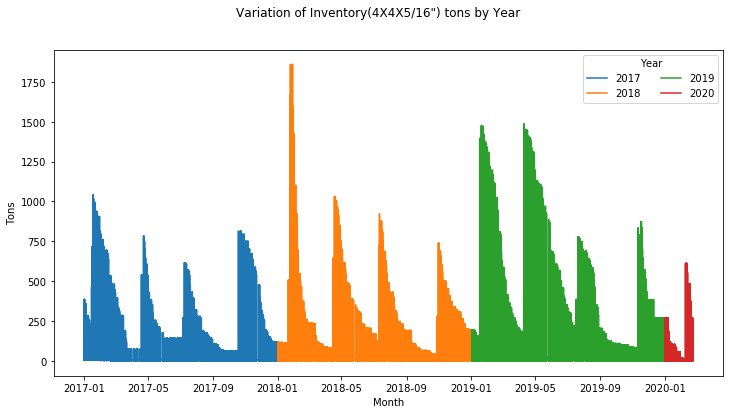

In [105]:
#creating df for each year
year_2017 = block_df[block_df.year == 2017]
year_2018 = block_df[block_df.year == 2018]
year_2019 = block_df[block_df.year == 2019]
year_2020 = block_df[block_df.year == 2020]

#Create figure and plots
fig_dims = (12,6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Variation of Inventory(4X4X5/16") tons by Year')

ax.plot(year_2017.calendar_day, year_2017["tons"], label=2017)
ax.plot(year_2018.calendar_day, year_2018["tons"], label=2018)
ax.plot(year_2019.calendar_day, year_2019["tons"], label=2019)
ax.plot(year_2020.calendar_day, year_2020["tons"], label=2020)

#Create legend & axis names
plt.legend(loc="best", title="Year", ncol=2)
ax.set_xlabel("Month")
ax.set_ylabel("Tons")